In [9]:
#Importing required libraries
#***MUST BE RUN***
import pandas as pd
import requests
import json
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import json_normalize
from functools import reduce

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

timezone_shift = 4*(60*60) #hardcoding eastern timezone


In [11]:
#User Query
#***MUST BE RUN***

#Ask user for login info
user = input('Enter your username or email: ')
pw = input('Enter your password: ')

#Authenticate the user
s = requests.Session()
payload = {'username_or_email': user, 'password':pw}
s.post('https://api.onepeloton.com/auth/login', json=payload)

Enter your username or email: dk;s
Enter your password: fs;ldfk


In [6]:
#Fetching data from the input username and password
#***MUST BE RUN***
print('Retrieving info... Please wait until instructed to continue')

#First API Call (User Info)
#Get User ID to pass into other calls
me_url = 'https://api.onepeloton.com/api/me'
response = s.get(me_url)
apidata = s.get(me_url).json()

#Flatten API response into a temporary dataframe
df_my_id = json_normalize(apidata, 'id', ['id'])
df_my_id_clean = df_my_id.iloc[0]
my_id = (df_my_id_clean.drop([0])).values.tolist()




#Second API Call (Workout Details) 
url = 'https://api.onepeloton.com/api/user/{}/workouts?joins=ride,ride.instructor&limit=250&page=0'.format(*my_id)
response = s.get(url)
data = s.get(url).json()

#Flatten API response into a temporary dataframe
df_workouts_raw = json_normalize(data['data'])

#Extract only the important coumns from this query
df_workouts = df_workouts_raw[['id','created_at','end_time','fitness_discipline','ride.difficulty_level']].copy()

df_workouts['Duration'] = round((df_workouts['end_time'] - df_workouts['created_at'])/60,2)
df_workouts['Date'] = pd.to_datetime((df_workouts['created_at']-timezone_shift)*1000000000).dt.date
df_workouts = df_workouts.drop(columns = ['created_at', 'end_time'])


#Print Message Workout Data Complete
print('Workout Data processing complete')




#Third API Call (Workout Metrics)
print('Fetching workout metrics...')
#Create Dataframe of Workout IDs to run through our Loop
df_workout_ids = df_workouts.filter(['id'], axis=1)

#Define the imputs for the for loop
workout_ids = df_workout_ids.values.tolist()
workout_ids2 = [i[0] for i in workout_ids]

#Create empty dataframes to write iterations to
df_tot_metrics = pd.DataFrame([])
df_avg_metrics = pd.DataFrame([])

for workout_id in workout_ids2:
     response2 = s.get('https://api.onepeloton.com/api/workout/{}/performance_graph?every_n=300'.format(workout_id))
     data2 = response2.json()
     #Flatten API response into a temporary dataframe - exception handling because each workout type has a 
     #different structure to the API response, with different metrics.  Additionally, this call also generates
     #a number of rows so we have to transpose and flatten the dataframe.
     try:
          df_avg_raw = json_normalize(data2['average_summaries'])
     except:
          pass
     else:
          df_avg_raw = json_normalize(data2['average_summaries'])
          df_avg_stg = df_avg_raw.T
     try:
          df_avg_stg.columns = df_avg_stg.iloc[0]
     except:
          pass
     else:
          df_avg_stg.columns = df_avg_stg.iloc[0]
          df_avg = df_avg_stg.drop(['display_name', 'slug', 'display_unit'])
          df_avg['id'] = workout_id
     try:
          df_tot_raw = json_normalize(data2['summaries'])
     except:
          pass
     else:
          df_tot_raw = json_normalize(data2['summaries'])
          df_tot_stg = df_tot_raw.T
     try:
          df_tot_stg.columns = df_tot_stg.iloc[0]
     except:
          pass
     else:
          df_tot_stg.columns = df_tot_stg.iloc[0]
          df_tot = df_tot_stg.drop(['display_name', 'slug', 'display_unit'])
          df_tot['id'] = workout_id
     
    #Append each run through the loop to the dataframe
     df_tot_metrics = df_tot_metrics.append(df_tot, sort=False)
     try:
          df_avg_metrics = df_avg_metrics.append(df_avg, sort=False)
     except:
          pass
     else:
          df_avg_metrics = df_avg_metrics.append(df_avg, sort=False)

df_tot_metrics_clean = df_tot_metrics.drop_duplicates()
df_avg_metrics_clean = df_avg_metrics.drop_duplicates()
df_workout_metrics = df_avg_metrics_clean.merge(df_tot_metrics_clean, left_on='id', right_on='id', how='right')
print('Workout Metrics processing complete')


#Merge details and metrics
df_merged = df_workouts.merge(df_workout_metrics, left_on='id', right_on='id', how='left')
df_merged = df_merged[df_merged.fitness_discipline == 'cycling']
df_merged['Avg Calories'] = df_merged['Calories']/df_merged['Duration']

#Clean up
df_universal = df_merged.drop(columns = ['id','fitness_discipline'])
df_universal = df_universal[['Date', 'Duration', 'ride.difficulty_level', 'Distance', 'Avg Output', 'Avg Cadence', 'Avg Resistance', 'Avg Speed', 'Avg Calories', 'Calories', 'Total Output']]
df_universal = df_universal.rename(columns={"ride.difficulty_level": "Difficulty"})


#Print the merged dataframes
print("All processing complete. You may now continue")
df_universal


Retrieving info... Please wait until instructed to continue
Workout Data processing complete
Fetching workout metrics...
Workout Metrics processing complete
All processing complete. You may now continue


,Date,Duration,Difficulty,Distance,Avg Output,Avg Cadence,Avg Resistance,Avg Speed,Avg Calories,Calories,Total Output
0,2020-12-15,5.03,intermediate,1.32,94,79,39,15.8,10.9344,55,28
1,2020-12-15,20.98,intermediate,7.41,229,71,59,22.2,14.1563,297,275
2,2020-12-14,4.98,None,1.32,97,73,41,16,12.0482,60,29
3,2020-12-14,31.00,None,10.27,191,69,55,20.6,14.1613,439,343
5,2020-12-12,5.00,None,1.41,114,75,42,17,10.4,52,34
...,...,...,...,...,...,...,...,...,...,...,...
244,2020-07-26,6.98,intermediate,1.55,75,79,35,14.4,8.59599,60,29
245,2020-07-26,21.00,intermediate,5.87,127,82,42,17.6,9.85714,207,152
246,2020-07-25,21.00,beginner,5.57,112,79,40,16.7,10.0952,212,134
247,2020-07-24,20.98,beginner,5.75,124,83,40,17.3,8.81792,185,149


How many active days would you like displayed? (write ALL for complete list)
Days: 15
Displaying results for the past 15 active days


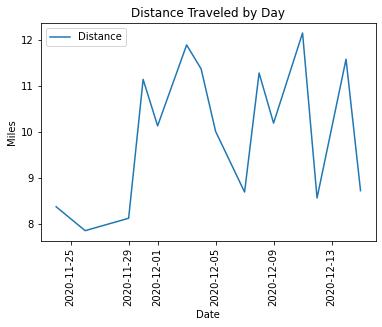

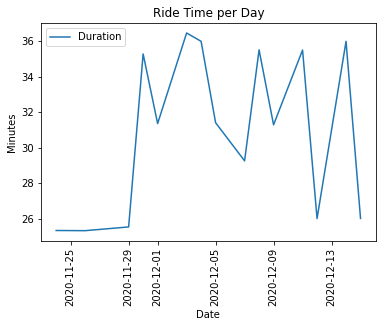

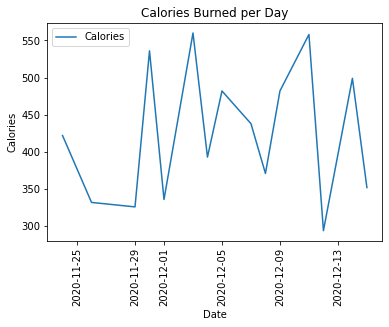

10.01  Miles Per Day
31.08  Minutes Per Day
425.4  Calories Per Day


,Distance,Duration,Calories
Date,,,
2020-11-24,8.38,25.33,422.0
2020-11-26,7.86,25.32,332.0
2020-11-29,8.13,25.53,326.0
2020-11-30,11.15,35.27,536.0
2020-12-01,10.14,31.35,336.0
...,...,...,...
2020-12-09,10.20,31.28,482.0
2020-12-11,12.16,35.49,558.0
2020-12-12,8.57,26.00,294.0


In [7]:
#Stats by Day
#***Optional***

#Ask user how many active days to track
print("How many active days would you like displayed? (write ALL for complete list)")
days = input('Days: ')


#Merge data from the same day
df_totals = df_universal[['Date','Distance','Duration','Calories']].copy()
aggregation_functions = {'Distance': 'sum', 'Duration': 'sum', 'Calories': 'sum'}
df_totals = df_totals.groupby(df_totals['Date']).aggregate(aggregation_functions)

#Cutting off data at desired time
try:
    num_days = int(days)
    df_totals = df_totals.tail(num_days)
    print("Displaying results for the past "+days+" active days")
except ValueError:
    print("Displaying All Results")


#Plot distance by day
df_totals.plot.line(y = 'Distance')
plt.title("Distance Traveled by Day")
plt.ylabel("Miles")
plt.xticks(rotation=90)
plt.show()

#Plot ride time per day
df_totals.plot.line(y = 'Duration')
plt.title("Ride Time per Day")
plt.ylabel("Minutes")
plt.xticks(rotation=90)
plt.show()

#Plot calories burned per day
df_totals.plot.line(y = 'Calories')
plt.title("Calories Burned per Day")
plt.ylabel("Calories")
plt.xticks(rotation=90)
plt.show()

#Print averages
print(round(df_totals.Distance.mean(),2), " Miles Per Day")
print(round(df_totals.Duration.mean(),2), " Minutes Per Day")
print(round(df_totals.Calories.mean(),2), " Calories Per Day")

df_totals

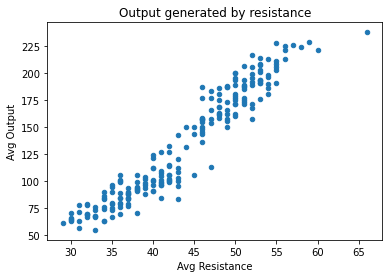

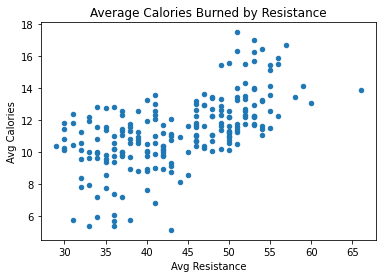

In [8]:
#Scatter plots based on resistance
#***Optional***

#Plot Output based on resistance
df_universal.plot.scatter(x = 'Avg Resistance',y = 'Avg Output')
plt.title("Output generated by resistance")
plt.show()

#Plot Calories based on resistance
df_universal.plot.scatter(x = 'Avg Resistance',y = 'Avg Calories')
plt.title("Average Calories Burned by Resistance")
plt.show()